# Dependencias

In [4]:
import numpy as np
import os
import tensorflow as tf
# dependencia externa cuyo código se adjunta en el mismo directorio en el que se encuentra este archivo
import inkml2img
import re
import json
import xml.etree.ElementTree as ET
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from jiwer import wer

In [5]:
dir = os.path.abspath('')
dir

'c:\\Users\\Yo\\Desktop\\ML_OHME'

# Preprocesamiento

In [ ]:
# <<<<<<<<<<<<<<NO ES NECESARIO EJECUTAR>>>>>>>>>>>>>>>>>>>>>>>

# En esta celda se convierten los archivos inkml a .jpg con ayuda del modulo inkml2img
# PATH indica la ubicacion de los archivos .inkml
PATH = dir+r"\\CROHME\\TrainINKML"
# DIR_PATH indica el directorio donde se guardarán las imagenes
DIR_PATH = dir+r"\\CROHME\\TrainINKML\\images"
# se obtiene el nombre de las carpetas que contienen los archivos .inkml
dataSets = os.listdir(PATH)
# se genera una lista con listas vacias (la cantidad de carpetas en dataSets)
arr = [[] for _ in range(len(dataSets))]
print(dataSets)
# se itera por cada carpeta de archivos .inkml
for i in range(len(dataSets)):
    # se agrega a la lista los archivos en determinada carpeta (la de la iteracion actual)
    arr[i] = os.listdir(PATH+'\\'+dataSets[i])
    # se itera por los archivos .inkml de la carpeta
    for t in arr[i]:
        # si la extension no es .lg
        if ('.lg' not in t):
            # se llama a la funcion inkml2img del modulo hominimo, especificando la ruta del inkml y la ruta a guardar la imagen
            inkml2img.inkml2img(PATH+'\\'+dataSets[i]+'\\'+t,DIR_PATH+'\\'+t[:-5]+'jpg')
            #print(t)

In [ ]:
# <<<<<<<<<<<<<<NO ES NECESARIO EJECUTAR>>>>>>>>>>>>>>>>>>>>>>>


# en esta celda se obtienen los labels (el ground truth en latex) asociado a cada archivo .inkml
# Paths indicando la direccion donde guardar y leer los archivos del conjunto de datos
DIR_PATH = dir+r"\\CROHME\\TrainINKML\\"
LABELS_PATH = dir+r"\\CROHME\TrainINKML\\"
# diccionario donde el ground truth se guardara para cada archivo
items = {}
index = 0
count = 0
# se itera por la cantidad de carpetas que contienen archivos .inkml
for t in arr:
    # se itera por cada archivo inkml
    for i in t:
        if (".lg" not in i):
            # se obtiene el path del archivo concatenando DIR_PATH con el nombre de la carpeta y del archivo
            imgPath = DIR_PATH+"\\"+ dataSets[index]+ "\\"+i
            # dado que .inkml es un tipo de XML, tiene una estructura de arbol, por lo que se utiliza 
            # la funcion ET.parse para hacer uso de esta estructura
            tree = ET.parse(imgPath)
            # se otbiene la raiz del archivo (primera etiqueta en el .inkml)
            root = tree.getroot()
            count =0
            # se itera por cada hijo de la raiz
            for item in root:
                # si el hijo posee texto entonces es posible que contenga el ground truth (label) deseado
                if item.text:
                    # existen tres posibilidades debido a la forma en que fueron codificados los archivos en distintas carpetas
                    # el primero es que el groud truth en latex se encuetre entre simbolos de dolar $
                    if "$" in item.text:
                        current = item.text
                        # se añade como key del diccionario el nombre del archivo y se le asocia el ground truth en latex
                        items[DIR_PATH+"\\"+ dataSets[index]+ "\\"+i] = current[1:-1]
                        break
                    # para la carpeta MathBrush cuyo formato de groundTruth es distinto
                    if "\\" in item.text and dataSets[index] == "MathBrush":
                        current = item.text
                        items[DIR_PATH+"\\"+ dataSets[index]+ "\\"+i] = current[1:-1]
                        break
                    # para la carpeta KAIST el latex se encuentra sin elementos externos, por lo que se agrega sin mas
                    if (count ==1 and dataSets[index]=="KAIST" and len(item.text)>2):
                        current = item.text
                        items[DIR_PATH+"\\"+ dataSets[index]+ "\\"+i] = current
                        break
                count +=1
    index +=1 
# se verifica que el comando log no se encuentre como una secuencia de letras separadas
for key in items:
    if ('l o g' in items[key]):
        # si se encuentra se reemplaza por su respectivo comando en latex correcto
        items[key] = items[key].replace('l o g', '\\log')
# se guarda el diccionario en formato json
with open(dir+r"\\CROHME\\TrainINKML\\labels.json", 'w') as f:
    json.dump(items, f, indent=4)

In [ ]:
# <<<<<<<<<<<<<<NO ES NECESARIO EJECUTAR>>>>>>>>>>>>>>>>>>>>>>>


# se realiza un filtrado de los groud truth para separar cada comando, letra y numero presente en el dataset
# establece los comandos a borrar, ya que no proporcionan informacion relevante para la ecuacion
delete = ['\\Bigg','\\left','\\right','\\Big','\\mathrm']
# comandos a reemplazar por el comando latex correcto
replace = {'\\to':'\\rightarrow', '\\gt':'>', '\\lt':'<'}
# simbolos a los que se les añade espacios en blanco antes y despues para un mejor tratamiento
add = ['_','{','}','=','(',')','-','+','^','[',']', ',']
count = 0
# se iteran los archivos .inkml, items representa el mismo diccionario guardado en labels.json
for key in items:
    # si existe alguno de los comandos descritos en las listas y diccionario anteriores se realizan la soperaciones
    # correspondientes
    for dele in delete:
        if dele in items[key]:
            items[key] = items[key].replace(dele, "")
    for rep in replace:
        if (rep in items[key]):
            items[key] = items[key].replace(rep, replace[rep])
    for it in add:
        if (it in items[key]):
            items[key] = items[key].replace(it, " "+it+" ")
    # se agrega un espacio en blanco antes de \\ para que pueda diferenciarse a los comandos del resto de letras o numeros
    if ('\\' in items[key]):
        items[key] = items[key].replace('\\', " \\")
    # se separa el ground truth, siendo la condicion para separa el que existan uno o mas espacios en blanco entre caracteres
    items[key] = re.split(r'\s+', items[key])
    count = 0
    # se itera sobre la lista generada de letras, numeros, simbolos y comandos para cada archivo inkml
    # separando los caracteres que se encuentren juntos y no sean parte de un comando, 
    # por ejemplo 'abc' se separa en 'a', 'b', 'c'
    for a in items[key]:
        if ('\\' not in a and len(a)>1):
            uno = items[key][:count]
            dos = re.split('', a)[1:-1]
            tres = items[key][count+1:]
            count+= len(dos)-1
            uno.extend(dos)
            uno.extend(tres)
            items[key] = uno
        count+=1
    if (items[key][-1]==""):
        items[key] = items[key][:-1]
    if (items[key][0]==""):
        items[key] = items[key][1:]
# se guarda en labels.json
with open(dir+r"\\CROHME\\TrainINKML\\labels.json", 'w') as f:
    json.dump(items, f, indent=4)

In [6]:
# se define el numero maximo de palabras a tokenizar
num_words = 1000
# token para labels desconocidas
oov_token = '<UNK>'
# parametros de inicializacion del tokenizer de tensorflow
pad_type = 'post'
trunc_type = 'post'

items = {}
# se obtienen las listas de labels (numeros, comandos latex, simbolos y letras) para cada archivo inkml
# derivados del preprocesamiento previo
with open(dir+r"\\CROHME\\TrainINKML\\labels.json", 'r') as f:
    items = json.load(f)
tokens = {}
count = 0
# se itera para cada archivo
for key in items:
    # se convierte a string
    items[key] = ' '.join(map(str, items[key]))
    # se anade al inicio y final los labels start y end para indicar inicio y final del ground truth
    items[key] = '<start> '+items[key] + ' <end>'
    # se vuelven a separar
    items[key] = re.sub(r"\s+", " ", items[key])
# se obtiene la cantidad de archvios inkml a tratar
keys = list(items.keys())
# se anade el groud truth de cada archivo a una lista
data = [ items[key] for key in keys ]
print(data[0])
# se instancia la funcion tokenizer con los parametros establecidos en un principio
tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token, filters='', lower=False)
# se obtienen los tokens para el conjunto de datos, es decir, a cada comando de latex, letra, numero o simbolo
# utilizado se le asigna un numero entero en base a su frecuencia de aparicion
tokenizer.fit_on_texts(data)
# se define la cantidad de palabras o tokens
word_index = tokenizer.word_index
# se guardan los tokens en tokens.json
with open(dir+r"\\CROHME\\TrainINKML\\tokens.json", 'r') as f:
        word_index = json.load(f)
tokenizer.word_index = word_index
# se convierten los labels a tokens para cada archivo inkml
# por ejemplo ['a','b','c'] se convierte a [1,2,3] asumiendo que estos son sus tokens
train_sequences = tokenizer.texts_to_sequences(data)
# se obtiene la longitud del label mas grande
maxlen = max([len(x) for x in train_sequences])
# se asocian los tokens a cada archivo haciendo un pad hacia la maxima longitud
# tal que todos los archivos tenga por label una lista de la misma longitud, rellenando con ceros
# aquellos tokens que se encuentran en una longitud mayor al verdadero para determinado archivo
train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

<start> S = ( \sum _ { i = 1 } ^ { n } \theta _ i - ( n - 2 ) \pi ) r ^ 2 <end>


In [ ]:
# <<<<<<<<<<<<<<NO ES NECESARIO EJECUTAR>>>>>>>>>>>>>>>>>>>>>>>


# se cargan los datos generados anteriormente: los tokens y etiquetas sin toquenizar de los
# archivos del dataset
LABELS_PATH = r"/content/drive/My Drive/Colab Notebooks/TrainINKML"
tokens = {}
files_imgs = {}
with open("/content/drive/My Drive/Colab Notebooks/TrainINKML/tokens.json", 'r') as f:
    tokens = json.load(f)
tokensPerFile = {}
items = {}
with open("/content/drive/My Drive/Colab Notebooks/TrainINKML/labels.json", 'r') as f:
    items = json.load(f)
# se guardan los tokens por archivo inkml haciendo referencia ahora a la imagen 
# generada a partir del archvio inkml
for key in items:
    newKey = LABELS_PATH +'/images/'+ key[len(LABELS_PATH)+15:][:-6].replace('\\','/')+'.jpg'
    tokensPerFile[newKey] = []
    files_imgs[newKey] = LABELS_PATH + key[43:].replace('\\','/')
    for command in items[key]:
        tokensPerFile[newKey].append(tokens[command])
# se guarda el conjunto de datos tokenizado en un formato json para su posterior uso
with open("/content/drive/My Drive/Colab Notebooks/TrainINKML/labelsPerFile.json", 'w') as f:
    json.dump(tokensPerFile, f, indent=4)
with open("/content/drive/My Drive/Colab Notebooks/TrainINKML/files_img.json", 'w') as f:
    json.dump(files_imgs, f, indent=4)

# Estructura del modelo

In [8]:
# se define la arquitectura del encoder en base a Zhang (2017)
class FCN_encoder(tf.keras.Model):
    def __init__(self, dropout_rate = 0.2):
        super(FCN_encoder, self).__init__()
        # super dentro del constructor permite que la clase herede y se convierta en un objeto de Keras
        
        # bloque de convolucion 1, 32 filtros
        # cada capa convolucional es seguida por un batch normalization y una capa de activacion
        # relu, el movimiento del kernel de convolucion se establece como 1 y
        # la dimension del kernel se establece como 3x3
        self.conv_1_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1)
        self.batch_1_1 = tf.keras.layers.BatchNormalization()
        self.act_1_1 = tf.keras.layers.Activation('relu')
        self.conv_1_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1)
        self.batch_1_2 = tf.keras.layers.BatchNormalization()
        self.act_1_2 = tf.keras.layers.Activation('relu')
        self.conv_1_3 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1)
        self.batch_1_3 = tf.keras.layers.BatchNormalization()
        self.act_1_3 = tf.keras.layers.Activation('relu')
        self.conv_1_4 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1)
        self.batch_1_4 = tf.keras.layers.BatchNormalization()
        self.act_1_4 = tf.keras.layers.Activation('relu')
        
        # maxpooling para reducir el tamaño
        self.maxPool_1 = tf.keras.layers.MaxPooling2D()
        
        # bloque convolucional 2, 64 filtros
        self.conv_2_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1)
        self.batch_2_1 = tf.keras.layers.BatchNormalization()
        self.act_2_1 = tf.keras.layers.Activation('relu')
        self.conv_2_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1)
        self.batch_2_2 = tf.keras.layers.BatchNormalization()
        self.act_2_2 = tf.keras.layers.Activation('relu')
        self.conv_2_3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1)
        self.batch_2_3 = tf.keras.layers.BatchNormalization()
        self.act_2_3 = tf.keras.layers.Activation('relu')
        self.conv_2_4 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1)
        self.batch_2_4 = tf.keras.layers.BatchNormalization()
        self.act_2_4 = tf.keras.layers.Activation('relu')

        self.maxPool_2 = tf.keras.layers.MaxPooling2D()

        self.conv_3_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1)
        self.batch_3_1 = tf.keras.layers.BatchNormalization()
        self.act_3_1 = tf.keras.layers.Activation('relu')
        self.conv_3_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1)
        self.batch_3_2 = tf.keras.layers.BatchNormalization()
        self.act_3_2 = tf.keras.layers.Activation('relu')
        self.conv_3_3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1)
        self.batch_3_3 = tf.keras.layers.BatchNormalization()
        self.act_3_3 = tf.keras.layers.Activation('relu')
        self.conv_3_4 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1)
        self.batch_3_4 = tf.keras.layers.BatchNormalization()
        self.act_3_4 = tf.keras.layers.Activation('relu')

        self.maxPool_3 = tf.keras.layers.MaxPooling2D()

        self.conv_4_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1)
        self.batch_4_1 = tf.keras.layers.BatchNormalization()
        self.act_4_1 = tf.keras.layers.Activation('relu')
        self.conv_4_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1)
        self.batch_4_2 = tf.keras.layers.BatchNormalization()
        self.act_4_2 = tf.keras.layers.Activation('relu')
        self.conv_4_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1)
        self.batch_4_3 = tf.keras.layers.BatchNormalization()
        self.act_4_3 = tf.keras.layers.Activation('relu')
        self.conv_4_4 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1)
        self.drop_4 = tf.keras.layers.Dropout(dropout_rate)
        self.batch_4_4 = tf.keras.layers.BatchNormalization()
        self.act_4_4 = tf.keras.layers.Activation('relu')

        self.maxPool_4 = tf.keras.layers.MaxPooling2D()
    # funcion de llamada de la clase, dentro de la cual se establece la secuencia de layers que el inpput seguirá
    # cada 'bloque' de codigo representa al conjunto de layers que comparten la misma cantidad de filtros en el
    # kernel de las capas convolucionales
    def call(self, inputs):
        
        x = self.conv_1_1(inputs)
        x = self.batch_1_1(x)
        x = self.act_1_1(x)
        x = self.conv_1_2(x)
        x = self.batch_1_2(x)
        x = self.act_1_2(x)
        x = self.conv_1_3(x)
        x = self.batch_1_3(x)
        x = self.act_1_3(x)
        x = self.conv_1_4(x)
        x = self.batch_1_4(x)
        x = self.act_1_4(x)
        x = self.maxPool_1(x)
        
        x = self.conv_2_1(x)
        x = self.batch_2_1(x)
        x = self.act_2_1(x)
        x = self.conv_2_2(x)
        x = self.batch_2_2(x)
        x = self.act_2_2(x)
        x = self.conv_2_3(x)
        x = self.batch_2_3(x)
        x = self.act_2_3(x)
        x = self.conv_2_4(x)
        x = self.batch_2_4(x)
        x = self.act_2_4(x)
        x = self.maxPool_2(x)
        
        x = self.conv_3_1(x)
        x = self.batch_3_1(x)
        x = self.act_3_1(x)
        x = self.conv_3_2(x)
        x = self.batch_3_2(x)
        x = self.act_3_2(x)
        x = self.conv_3_3(x)
        x = self.batch_3_3(x)
        x = self.act_3_3(x)
        x = self.conv_3_4(x)
        x = self.batch_3_4(x)
        x = self.act_3_4(x)
        x = self.maxPool_3(x)
        
        x = self.conv_4_1(x)
        x = self.batch_4_1(x)
        x = self.act_4_1(x)
        x = self.conv_4_2(x)
        x = self.batch_4_2(x)
        x = self.act_4_2(x)
        x = self.conv_4_3(x)
        x = self.batch_4_3(x)
        x = self.act_4_3(x)
        x = self.conv_4_4(x)
        x = self.drop_4(x)
        x = self.batch_4_4(x)
        x = self.act_4_4(x)
        x = self.maxPool_4(x)
        # el encoder retorna el feature map generado par la ultima capa de max pooling
        return x
    # se instancia una clase que permite conocer el tamaño de los parametros dentro de la red.
    def model(self):
        input = tf.keras.layers.Input(shape=(150, 180, 1))
        return tf.keras.Model(inputs = input, outputs = self.call(input) )
print(FCN_encoder().model().summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 180, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 178, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 178, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 148, 178, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 176, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 146, 176, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 146, 176, 32)      0     

In [10]:
# el modelo de atencion es instanciado
class Attender(tf.keras.Model):
    def __init__(self):
        super(Attender, self).__init__()
        # se instancia los distintos dense layers parametrizados en Zhang
        
        # representa la capa que se utiliza para aprender del hidden state anterior del decoder
        self.W_1 = tf.keras.layers.Dense(128)
        # capa que aprendera del feature map generado por el encoder
        self.U_a = tf.keras.layers.Dense(128)
        # la dimension de atencion es 128
        self.V_a = tf.keras.layers.Dense(128)
    
    def call(self, a, h):
        # se espanden dimensiones para el hidden state
        h_t = tf.expand_dims(h, 1)
        # se calcula el estado intermedio llamando a los dense layers y la funcion de tangente 
        # hiperbolica con la suma de los dos dense layers que reciben como parametro el hidden state
        # y el vector de anotacion
        e_ti = self.V_a( (tf.nn.tanh( self.W_1(h_t) + self.U_a(a))))
        # se aplica la activacion softmax al resultado
        a_ti = tf.nn.softmax(e_ti)
        # se calcula el vector de contexto multiplicando los coeficientes a_ti por el vector de anotacion
        context = a_ti * a
        # se obtiene la suma del resutado de la multiplicacion anterior
        context = (tf.reduce_sum(tf.reduce_sum(context, axis =1), axis=1))
        # se regresa el vector de contexto y los coeficientes a_ti
        return context     

In [11]:
# se define el modelo decoder que utiliza el gru
class GRU_decoder(tf.keras.Model):
    def __init__(self, dimension, units, label_len):
        super(GRU_decoder, self).__init__()
        # las unidades del gru
        self.units = units
        # la capa de embedding, establecida en Zhang como E
        self.embedding = tf.keras.layers.Embedding(label_len, dimension)
        # la capa del gru, se especifica que se desea el regreso de las secuencias y el ultimo estado calculado
        self.gru = tf.keras.layers.GRU( self.units, return_sequences=True, return_state = True, recurrent_initializer='glorot_uniform')
        # dense layers para el calculo de las probabilidades para cada palabra en el diccionario de palabras
        # es decir, los tokens
        # dense layer utilizado para la salida del GRU
        self.fc1 = tf.keras.layers.Dense(128)
        # dense layer utilizado para aprender del vector de contexto generado
        self.fc2 = tf.keras.layers.Dense(128)
        # dense layer utilizado para aprender de la salida anterior del decoder
        self.fc3 = tf.keras.layers.Dense(128)
        # la ultima capa se define con una activacion softmax
        self.fc4 = tf.keras.layers.Dense(128, activation='softmax')
        # se instancia el modelo de atencion
        self.attention = Attender()
      
    def call(self, a,x, h):
        # la llamada recibe la salida del encoder, la entrada del decoder (su salida anterios) 
        # y el estado anterior del decoder
        # se llama al modelo de atencion y se recibe el vector de contexto y los coeficientes de atencion
        context_v = self.attention(a,h)
        x = self.embedding(x)
        # se anade el contexto a la entrada del decoder para utilizar el conocimeinto previo
        t = tf.concat([context_v,x], axis =-1)
        # se expanden las dimensiones para hacer compatible el tensor con la entrada del GRU
        t = tf.expand_dims(t, 1)
        # se alimenta al gru con dicha informacion y se obtiene una salida y su estado actual
        out, state = self.gru(t)
        # se reduce la dimension de la salida del gru para hacer posible su 
        out = tf.reduce_sum(out, axis=1)
        
        # es necesario calcular las probabilidades condicionales, por lo que se utiliza 
        # la metodologia descrita por zhang al sumar las salidas de las capas 
        # que usan la informacion de distintias secciones del modelo encoder-decoder
        # como entrada de una capa final en la cual se realiza la clasficacion
        a = self.fc1(out)
        b = self.fc2(context_v)
        c = self.fc3(x)
        # se suman los resultados de cada capa densa
        res = a+b+c
        # se obtienen las probabilidades gracias al softmax del ultimo layer
        res = self.fc4(res)
        # se regresan las probabilidades, el estado y los coeficientes de atencion
        # las probabilidades corresponden a un tensor que posee las siguientes dimensiones:
        # (tamano_batch, cantidad de palabras) donde la cantidad de palabras es la misma
        # que los tokens producidos durante el preprocesamiento.
        return res, state

    @classmethod
    def from_config(cls, config):
        return cls(**config)
    # funcion especial para inicializar la entrada del GRU por primera vez como un tensor
    # de ceros, establecido como la forma mas eficiente de inicializar este t
    def reset(self, batch):
        return tf.zeros((batch,3, self.units))

# Definicion de funciones para entrenamiento

In [12]:
# instanciacion del encoder
encoder = FCN_encoder()
# isntanciacion del decoder, con valores para la dimension del embedding, del gru y la cantidad de tokens
decoder = GRU_decoder(128,128,len(list(word_index.keys()))+1)
# se define una funcion de optimizacion para el modelo, el cual permite realizar la optimizacion en base
# al gradiente de los errores
optimizer = tf.keras.optimizers.Adam()
# definimos el tipo de calculo para los errores o perdiada entre los correspondientes labels del ground 
#truth de cada imagen y las predicciones realizadas por el modelo
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

In [13]:
# se define una fucnion de loss (perdida o error) que recibe como parametro un label del ground truth por imagen 
# en el batch las matrices de prediccion asociadas a cada una de esas imagenes
def loss_function(real, pred):
    # se realiza una conversion del tipo de dato para las probabilidades de las predicciones
    pred = tf.cast(pred, tf.float32)
    # se establece una mascara para aquellas imagenes cuyo label sea 0, es decir, que
    # es el padding agregado y que de esta forma no se considere su error para el error general
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    # se calcula el error
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    # se anade la mascara al los obtenido
    loss_ *= mask
    # se retorna la media de las perdidas para las imagenes en el batch
    return tf.reduce_mean(loss_)

In [14]:
# se define una funcion para el calculo de presicion debido a que el padding en el groundTruth de las
# imagenes implica que los ceros utilizados para ello seran tomados en cuenta durante su calculo
# con la funcion propia de tensorflow
def accuracy(groundTruth, pred):
    # recibe los labels correctos del batch y las predicciones para cada una de las clases (127)
    # se obtiene el argmax o el mayor valor de cada prediccion
    pred_values = K.cast(K.argmax(pred, 1), dtype='int32')
    # se establece cuales de dichas predicciones son verdaderas con base al groundTruth o etiqueta
    correct = K.cast(K.equal(groundTruth, pred_values), dtype='float32')
    # se utiliza una mascara para establecer aquellos espacios dentro de la etiqueta que representan un
    # cero utilizado para el padding
    mask = K.cast(K.greater(groundTruth, 0), dtype='float32')
    # se toman en cuenta solamente aquellos valores que no sean cero
    n_correct = K.sum(mask * correct)
    # se calcula la cantidad de etiquetas del groundTruth que no son padding
    n_total = K.sum(mask)
      # se retorna el ratio representando la fraccion de predicciones correctas para esta seccion del batch
    return n_correct / n_total

In [15]:
data = {}
# se obtienen los tokens por imagen
LABELS_PATH = dir+"\\CROHME\\TrainINKML\\labelsPerFile.json"
with open(LABELS_PATH,  'r') as f:
    data = json.load(f)
    f.close()
    

In [16]:
files_img = {}
# se obtienen los nombres de las imagenes
with open(dir+"\\CROHME\\TrainINKML\\files_img.json", 'r') as f:
    files_img = json.load(f)
    f.close()
for i in list(files_img.keys()):
    files_img[dir+'\\CROHME\\TrainINKML'+i] = files_img.pop(i)
keys = list(files_img.keys())
for i in list(data.keys()):
    data[dir+'\\CROHME\\TrainINKML'+i] = data.pop(i)
files = list(data.keys())
# se obtiene el dataset a partir del diccionario que contiene los tokens por archivo
list_ds = tf.data.Dataset.list_files(files)

# funcion que obtiene la imagen y su label, tiene como parametro el path de la imagen
def getImages(f):
    # se obtiene el indice del archivo para obtener sus labels (tokens)
    index = keys.index(f)
    # se lee la imagen desde su fuente
    image = tf.io.read_file(f)
    # se decodifica el formato jpg y se establece como imagen en un solo canal, es decir
    # blanco y negro
    image = tf.image.decode_jpeg(image, channels = 1)  
    # se convierte su tipo de dato a flotante
    image = tf.image.convert_image_dtype(image, tf.float32)
    # se redimensiona para que concuerde con el input del modelo (encoder)
    image = tf.image.resize(image, [150, 180] ) 
    # se retorna la imagen (su matriz de pixels) y su label
    return image, train_padded[index]

# instancia el dataset a utilizar como un mapeo de los archvios dentro de list_ds que manda llamar a la funcion getProcessedImages
labeledDataset = list_ds.map(lambda x: tf.py_function(getImages, [x], [tf.float32, tf.int32]), num_parallel_calls=tf.data.AUTOTUNE)

# solo para verificar que funciona, imprime las dimensioens de una imagen del dataset y su label
for image, label in labeledDataset.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (150, 180, 1)
Label:  [ 4  2 20  2 49  3  9 13 91 14  3  5  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [17]:
# se utiliza un shuffle para revolver las imagenes dentro del dataset y evitar
# que imagenes continuas siempre sean tomadas dentro del mismo batch
labeledDataset = labeledDataset.shuffle(buffer_size=20)
# se establece el tamano de batch como 8, es decir, se ingresara al entrenamiento paquetes de 8 imagenes
labeledDataset = labeledDataset.batch(8)

# Entrenamiento

In [18]:
import random
# se define la funcion que entrena al modelo de encoder-decoder
# recibe como parametros el batch de imagenes y su ground truth (labels)
def train(image, groundTruth):
    loss = 0
    acc = []
    # el estado del gru se inicializa como ceros
    hidden = decoder.reset(groundTruth.shape[0])
    # el input del decoder se inicializa como un tensor con valores para el primer token en todas las imagenes
    input_decoder = tf.constant([word_index['<start>']] * groundTruth.shape[0])
    g1 = tf.random.Generator.from_seed(1)
    #input_decoder = tf.expand_dims([[word_index['<start>']]*3] * groundTruth.shape[0], 1)
    #print(input_decoder.shape, hidden.shape)
    # ciclo que permite el entrenamiento al generar un entorno donde las variables de entrenamiento son 'vigiladas'
    # durante el entrenamiento para poder corregirlas y ajusstar el modelo
    count = 0
    with tf.GradientTape() as tape:
        # se llama al encoder con la imagen la cual regresa el feature map con las caracteristicas extraidas de la imagen
        feature_map = encoder(image)
        # se itera por la cantidad de posibles palabras en un groundTruth
        for i in range(1, groundTruth.shape[1]):
            # para cada palabra se verifica si su tensor corresponde a solo valores en cero, para lo cual se rompe el ciclo
            # terminando el entrenamiento de este batch
            sum_ = tf.reduce_sum(groundTruth[:,i])
            allZero = tf.equal(sum_, 0)
            if (allZero):
                break
            # si existe por lo menos un label por predecir entonces se llama al decoder envindole 
            # su respectivo input, las salidas del encoder y el hidden state anterior
            pred, hidden = decoder(feature_map,input_decoder, hidden)
            # se calcula el error de las predicciones y se suma al actual para el batch
            loss += loss_function(groundTruth[:, i], pred)
            acc.append(accuracy(groundTruth[:, i], pred).numpy())
            #print(i,"loss:", loss)
            # la siguiente entrada para el decoder son las anotaciones para la iteracion actual
            # es decir, la anterior para la siguiente interacion (h-1)
            input_decoder = groundTruth[:, i]
            count +=1
    # se obtienen las variables a las que se les puede modificar los parametros para ajustarlas (entrenarlas)
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    # se obtiene el gradiente de error en base al error obtenido
    gradients = tape.gradient(loss, trainable_variables)
    # se realiza el ajuste en base al gradiente de error
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    # una vez que termina la entrada del batch se calcula el error total con el error obtenido
    total_loss = (loss / count)
    # se regresa el error dividido entre el numero de iteraciones para el batch,
    # el error total del batch (loss), asi como la media de la presicion en las predicciones del batch
    return loss, total_loss, sum(acc)/len(acc)

In [19]:
# funcion que itera sobre el dataset para entrenarlo
accuracies = []
losses = []
def trainData(dataset, loadEpoch, batchToLoad, load, EPOCHS = 2):
    print(len(dataset))
    # se itera por las epocas de entrenamiento
    for epoch in range(EPOCHS):
        # se inicializa la perdida como 0 para cada epoca de entrenamiento
        total_loss = 0
        num = 0
        # se hace iterable el dataset para obtener cada batch de images de forma individual
        # obteniendo el numero de batch, el tensor de imagenes (pixeles) y las etiquetas de cada imagen del batch
        for (batch, (img_tensor, target)) in enumerate(dataset):
            # se llama a la funcion de entrenamiento para cada batch enviando el tensor de imagenes y de labels
            # obteniendo los erroes
            print("batch",batch+1, end=" ")
            # dado que el ultimo batch tiene longitud distinta, se omite en cada epoca
            if (batch+1 == 1023):
                break
            # se llama a la funcion de entrenamiento, enviando como parametro el batch de imagenes y labels
            batch_loss, t_loss, acc = train(img_tensor, target)
            accuracies.append(acc)
            losses.append(t_loss)
            if (load):
                break
            # utilizado para guardar los pesos del encoder y decoder cada 100 batches
            if ((batch+1)%100 == 0 ):
                encoder.save_weights(dir+r"\CROHME\TrainINKML\train\enc\{0}_{1}.h5".format(loadEpoch+1+epoch, batch),
                    save_format='h5')
                decoder.save_weights(dir+r"\CROHME\TrainINKML\train\dec\{0}_{1}.h5".format(loadEpoch+1+epoch, batch),
                    save_format='h5')
            print("loss:", t_loss,"accuracy:",acc , end="\n")
            # se suma la perdida obtenida en cada batch
            total_loss += t_loss
            num +=1
        if not load:    
            print('Epoch {0:d}/{1:d}'.format(epoch+1, EPOCHS))
            print('===============>  train-loss=%.3f' % (total_loss/num))
        else:
            break
    print("accuracy:",sum(accuracies)/len(accuracies))
    print("loss:", sum(losses)/len(losses))

In [20]:
# se llama la funcion principal de entrenamiento para inicializar
trainData(labeledDataset, 0, 0, True, 1)
# se cargan los pesos de un entrenamiento anterior
encoder.load_weights(dir+r"\enc.h5")
decoder.load_weights(dir+r"\dec.h5")
# se llama a la funcion de entrenamiento para entrenar haciendo uso de los pesos
# obtenidos de los entrenamientos previos, continuando el aprendizaje
#trainData(labeledDataset)

1023
batch 1 accuracy: 0.013657407628165351
loss: tf.Tensor(2.003983, shape=(), dtype=float32)


In [40]:
print("accuracy:",sum(accuracies)/len(accuracies))
print("loss:", sum(losses)/len(losses))

accuracy: 0.5671823076589171
loss: tf.Tensor(4.6591296, shape=(), dtype=float32)


# Testing

In [21]:
items = {}
# se obtienen las listas de labels (numeros, comandos latex, simbolos y letras) para cada archivo inkml
import re
with open(dir+r"\CROHME\TestINKML\labels.json", 'r') as f:
    items = json.load(f)
for key in items:
    # se convierte a string
    items[key] = ' '.join(map(str, items[key]))
    # se anade al inicio y final los labels start y end para indicar inicio y final del ground truth
    items[key] = '<start> '+items[key] + ' <end>'
    # se vuelven a separar
    items[key] = re.sub(r"\s+", " ", items[key])
# se obtiene la cantidad de archvios inkml a tratar
keys = list(items.keys())
# se anade el groud truth de cada archivo a una lista
data = [ items[key] for key in keys ]
# se instancia la funcion tokenizer con los parametros establecidos en un principio
tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token, filters='', lower=False)

with open(dir+r"\CROHME\TrainINKML\tokens.json", 'r') as f:
        word_index = json.load(f)
tokenizer.word_index = word_index
# se convierten los labels a tokens para cada archivo inkml
# por ejemplo ['a','b','c'] se convierte a [1,2,3] asumiendo que estos son sus tokens
test_sequences = tokenizer.texts_to_sequences(data)
# se obtiene la longitud del label mas grande
maxlen = max([len(x) for x in test_sequences])
# se asocian los tokens a cada archivo haciendo un pad hacia la maxima longitud
# tal que todos los archivos tenga por label una lista de la misma longitud, rellenando con ceros
# aquellos tokens que se encuentran en una longitud mayor al verdadero para determinado archivo
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

In [22]:
data= {}
LABELS_PATH = dir+r"\CROHME\TestINKML\labelsPerFile.json"
with open(LABELS_PATH,  'r') as f:
    data = json.load(f)
    f.close()
files_img = {}
# se obtienen los nombres de las imagenes
with open(dir+r"\CROHME\TestINKML\files_img.json", 'r') as f:
    files_img = json.load(f)
    f.close()
for i in list(files_img.keys()):
    files_img[dir+'\\CROHME\\TestINKML'+i] = files_img.pop(i)
keys = list(files_img.keys())
for i in list(data.keys()):
    data[dir+'\\CROHME\\TestINKML'+i] = data.pop(i)
files = list(data.keys())
# se obtiene el dataset a partir del diccionario que contiene los tokens por archivo
list_ds = tf.data.Dataset.list_files(files)

# funcion que obtiene la imagen y su label, tiene como parametro el path de la imagen
def getImagesTest(f):
    index = keys.index(f)
    # se lee la imagen
    image = tf.io.read_file(f)
    # se decodifica el formato jpg y se establece como imagen en un solo canal, es decir
    # blanco y negro
    image = tf.image.decode_jpeg(image, channels = 1)  
    # se convierte su tipo de dato a flotante
    image = tf.image.convert_image_dtype(image, tf.float32)
    # se redimensiona para que concuerde con el modelo del encoder
    image = tf.image.resize(image, [150, 180] ) 
    # se retorna la imagen (su matriz de pixels) y su label
    return image, test_padded[index]

# define el dataset a utilizar como un mapeo de los archvios dentro de list_ds que manda llamar a la funcion getImagesTest
testDataset = list_ds.map(lambda x: tf.py_function(getImagesTest, [x], [tf.float32, tf.int32]), num_parallel_calls=tf.data.AUTOTUNE)

# solo para verificar que funciona, imprime las dimensioens de la imagen y su label
for image, label in testDataset.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (150, 180, 1)
Label:  [ 4 16  2 27  8  2 18  3 12  7 27  9  6  3  2 27  8  2 28  3  9 18 27 12
  6  3  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [23]:
# se hace shuffle al conjunto de daots de prueba y se establece un tamano de batch 
# similar al de entrenamiento
testDataset = testDataset.shuffle(buffer_size=20)
testDataset = testDataset.batch(8)
print(len(testDataset))

84


In [31]:
test_data = []
accuracies = []
losses = []
def test(image, groundTruth):
    global glob_hidden
    loss = 0
    acc = []
    temp = []
    # el estado del gru se inicializa como ceros
    hidden = decoder.reset(groundTruth.shape[0])
    # el input del decoder se inicializa como un tensor con valores para el primer token en todas las imagenes
    input_decoder = tf.constant([word_index['<start>']] * groundTruth.shape[0])
    count = 0
    # se llama al encoder con la imagen la cual regresa el feature map con las caracteristicas extraidas de la imagen
    feature_map = encoder(image)
    # se itera por la cantidad de posibles palabras en un groundTruth
    for i in range(1, groundTruth.shape[1]):
        # para cada palabra se verifica si su tensor corresponde a solo valores en cero, para lo cual se rompe el ciclo
        # terminando la prueba de este batch
        sum_ = tf.reduce_sum(groundTruth[:,i])
        allZero = tf.equal(sum_, 0)
        if (allZero):
            break
        # si existe por lo menos un label por predecir entonces se llama al decoder envindole 
        # su respectivo input, las salidas del encoder y el hidden state anterior
        pred, hidden = decoder(feature_map, input_decoder, hidden)
        temp.append([groundTruth[:,i], K.argmax(pred, 1)])
        # se calcula el error de las predicciones y se suma al actual para el batch
        loss += loss_function(groundTruth[:, i], pred)
        acc.append(accuracy(groundTruth[:, i], pred).numpy())
        
        #print(i,"loss:", loss)
        # la siguiente entrada para el decoder son las anotaciones para la iteracion actual
        # es decir, la anterior para la siguiente interacion (h-1)
        input_decoder = tf.argmax(pred,1)
        count +=1
    test_data.append(temp)
    # dado que es la prueba, se elimina la necesidad de calcular gradientes y ajustar los pesos
    # de los distintos layers del modelo
    # una vez que termina la entrada del batch se calcula el error total con el error obtenido
    total_loss = (loss / count)
    # se regresa el error, el error total y la presicion
    return loss, total_loss, sum(acc)/len(acc)

In [32]:
def testData(dataset):
    print(len(dataset))
    # se itera por las epocas de entrenamiento
    total_loss = 0
    num = 0
    # para cada batch de images en el dataset
    for (batch, (img_tensor, target)) in enumerate(dataset):
        # se llama a la funcion de entrenamiento para cada batch enviando el tensor de imagenes y de labels
        # obteniendo los erroes
        print("batch",batch+1, end=" ")
        if (batch+1 == 1023):
            break
        # se llama la funcion de prueba para obtener las predicciones y métricas relacionadas
        batch_loss, t_loss, acc = test(img_tensor, target)
        # se añade el accuracy y perdida a una lista en orden de obtener sus medias de prueba
        accuracies.append(acc)
        losses.append(t_loss)
        print("loss:", t_loss,"accuracy:",acc , end="\n")
        total_loss += t_loss
        num +=1
    print('===============>  train-loss=%.3f' % (total_loss/num))
        

In [ ]:
testData(testDataset)

In [25]:
# se muestran las medias de las mettricas geenradas
print("accuracy:",sum(accuracies)/len(accuracies))
print("loss:", sum(losses)/len(losses))

accuracy: 0.07122624531210295
loss: tf.Tensor(6.473276, shape=(), dtype=float32)


In [34]:
# calculo de la metrica WER

# se generan listas del tamano del conjunto de prueba para las etiquetas y predicciones
final_labels = [[] for _ in range(671)]
final_pred = [[] for _ in range(671)]
index = 0
# se itera sobre las predicciones generadas durante la prueba
for i in test_data:
    # dado que cada batch contiene informacion de 8 imagenes distintas, se itera sobre este
    for j in i:
        # se anaden las predicciones y etiquetas originales a sus respectivas listas
        for k, count in zip(j[0].numpy(), range(8)):
            final_labels[index+count].append(k)
        for k, count in zip(j[1].numpy(), range(8)):
            final_pred[index+count].append(k)
    index+=8
# se instancia la variable que guardará el valor de la métrica
WER_ = 0
# se itera durante el tamaño del conjunto de datos de prueba
# para obtener las predicciones en formato de texto
for k in range(671):
    # se genera una cadena de texto con las etiquetas correctas para la imagen
    a = ' '.join([str(i) for i in final_labels[k]])
    # se genera una cadena de caracteres con las predicciones estabelcidas por el modelo
    b = ' '.join([str(i) for i in final_pred[k]])
    # se utiliza la funcion wer del modulo jiwer, la cual requiere de entrada la cadena correcta y la predicha para
    # calcular la métrica, de esta forma se asbtrae el calculo de forma manual
    WER_ += wer(a,b)
# se imprime la media de la métrica al dividir la suma sobre ela cantidad de imagenes de prueba
print(WER_/671)

0.9243961303803582


In [35]:
# permite obtener solamente la matriz de ppixeles de una imagen para poder realizar 
# predicciones con la misma
def getPredImage(f):
    # se lee la imagen
    image = tf.io.read_file(f)
    # se decodifica el formato jpg y se establece como imagen en un solo canal, es decir
    # blanco y negro
    image = tf.image.decode_jpeg(image, channels = 1, dct_method = 'INTEGER_ACCURATE')  
    # se convierte su tipo de dato a flotante
    image = tf.image.convert_image_dtype(image, tf.float32)
    # se redimensiona para que concuerde con el modelo del encoder
    image = tf.image.resize(image, [150, 180] ) 
    # se retorna la imagen (su matriz de pixels)
    return image

In [27]:
# se importan las dependencias requeridas para la renderizacion de LaTeX de originales y predicciones
from sympy import *
from sympy.parsing.latex import parse_latex
import antlr4
# se establece el inicio de una impresion de LaTeX
init_printing()

[44, 11, 63, 15, 55, 9, 30, 53, 80, 9, 16, 2, 6, 3, 2, 18, 3, 13, 17, 12, 24, 14, 54, 5]
ANTLR runtime and generated code versions disagree: 4.9.3!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.3!=4.7.2


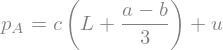

In [40]:
# imprime la etiqueta correcta
# se obtiene una muestra aleatoria del conjunto de prueba
k = np.random.randint(671)
# se impirmen sus etiquetas
print(final_labels[k])
# se obtiene su representacion en latex al mapear los tokens a su respectivo comando de latex, numero o letra
original = parse_latex(''.join([str(list(word_index.keys())[i-1] ) for i in final_labels[k][:final_labels[k].index(5)]]))
# se renderiza la expresión
original


In [42]:
# imrpime la prediccion generada en caso de poder ser renderizada, so no imprime los comandos de latex como texto.
print(' '.join([str(list(word_index.keys())[i-1]  ) for i in final_pred[k][:final_pred[k].index(5)]]))
# dado que es posible que la predicción no sea renderizable se intenta hacerlo
try:
    # si es posible se renderiza
    prediction_lat = parse_latex(' '.join([str(list(word_index.keys())[i-1] ) for i in final_pred[k][1:final_pred[k].index(5)]]))
    prediction_lat
except:
    # en caso contrario se establece el error
    print('error')

\frac { 1 } { a }
ANTLR runtime and generated code versions disagree: 4.9.3!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.3!=4.7.2


In [43]:
# puede cambiar el path por cualquier imagen que desee, ya sea de tamaño 150x180 o distinto
# ya que se aplica un resize al obtener la matriz de pixeles
image = dir+"\\imagenes_evaluacion\\eval_1.png"
# se obtiene la matriz de pixeles que representan a la imagen de prueba
img_val = tf.expand_dims(getPredImage(image),0)

image2 = dir+"\\imagenes_evaluacion\\eval_2.png"
img_val2 = tf.expand_dims(getPredImage(image2),0)

# se establece la entrada del decoder como la etiqueta de inicio de una epxresion (4)
input_decoder = tf.constant([4] * 1)
# se se instancia una lista donde almacenar predicciones
preds = []
# se define el hidden state inicial del decoder como un tensor inicializado con ceros con las mismas
# dimensiones que el feature map de salida del encoder
hidden = tf.constant([[[0.0]*128]*3]*1)
# se define el batch (no hay diferencia en utilizar la variable que guarda la matriz de la imagen, pero
# se utiliza por consistencia)
batch = img_val
# se realiza la predccion con el encoder ingresando la imagen
feature_map = encoder.predict(batch)

init_printing()
# se itera por la posible cantidad de etiquetas correctas a generar
for i in range(90):
    # se llama al decoder con el feature_map generado por en ecoder
    # su entrada (etiqueta predicha anteriormnente) y su hidden state anterior
    pred, hidden = decoder(feature_map, input_decoder, hidden)
    # se toma como predicción el valor con mayor probabilidad
    input_decoder = tf.argmax(pred, 1)
    # se anade la prediccion a la lista de predicciones
    preds.append(input_decoder)
    # si se encuentra la etiqueta representativa del final de expresion de termina la iteracion
    # ya que se habrá terminado con la predicción por parte del modelo.
    if (input_decoder.numpy()[0] == 5):
        break
# se toman las llaves del diccionario de tokens
keys = list(word_index.keys())
# se imprime la secuencia de latex generada por las predicciones
print(' '.join([str(list(word_index.keys())[i.numpy()[0]-1]  ) for i in preds]))
render = ''
# se añade en formato de texto la prediccion
for i in preds:
    print(i.numpy()[0], end=" ")
    render += keys[i.numpy()[0]-1] 
# la prediccion en formato de texto es formateada como latex e impresa
render = parse_latex(str(render))
render

\frac { 1 } { 2 } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } } }
16 2 6 3 2 7 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 ANTLR runtime and generated code versions disagree: 4.9.3!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.3!=4.7.2


In [169]:
keys[96] = "\\lt"
keys[105] = "\\gt"
keys[14]='='
keys[97] = '\\!'
keys[39] = '\\,'